In [271]:
import sys
sys.path.append("C:\\Users\josep\Documents\Anaconda\pkgs")
import help_tools
import wave_tools
import cv2
import h5py
from matplotlib import cm
import radar_tools
import numpy as np
from wave_tools import ConstructWave, surface_core, peak_tracking
from wave_tools import fft_interpolate, fft_interface, Spectrum
from wave_tools import SpectralAnalysis
import matplotlib.pyplot as plt
from help_tools import plotting_interface
from wave_tools import surface_core, fft_interface, dispersionRelation
from help_tools import plotting_interface, polar_coordinates, convolutional_filters, moving_average
from scipy.optimize import least_squares
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from scipy.fftpack import fftn, fftshift

In [272]:
sys.path.append("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW")
fileName ='shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5'
f = h5py.File('C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5', 'r')

In [273]:
psi = 0

In [274]:
x = f.get('x')
y = f.get('y')
z = f.get('z')
t = f.get('t')
k = f.get('k')
U = f.get('U')
Uk = f.get('Uk')
eta = f.get('eta')
x = np.array(x)
y = np.array(y)
z = np.array(z)
t = np.array(t)
k = np.array(k)
U = np.array(U)
Uk = np.array(Uk)
eta = np.array(eta)

In [275]:
dx = 7.5 
dy = 7.5
dt = 1

In [276]:
maxFrequency = 4.0 
# Approximate max  frequency to consider (converted to max wavenumber below) [rad/sec]

dk = 2*np.pi/(dx*min(eta.shape[0], eta.shape[1]))
# % wavenumber resolution of spectrum in each spatial window 
# (not strictly true if dx ~= dy, but value only needs to be approximate in practice)

kW = 1*dk
# Half width of wavenumbers bins [rad/m]

dk

0.012503851357571316

In [277]:
wavenumbers = np.arange(3 * dk, 0.305, dk)

In [278]:
wavenumbers

array([0.03751155, 0.05001541, 0.06251926, 0.07502311, 0.08752696,
       0.10003081, 0.11253466, 0.12503851, 0.13754236, 0.15004622,
       0.16255007, 0.17505392, 0.18755777, 0.20006162, 0.21256547,
       0.22506932, 0.23757318, 0.25007703, 0.26258088, 0.27508473,
       0.28758858, 0.30009243])

In [279]:
Nt, Nx, Ny = eta.shape

In [553]:
Kx = (2 * np.pi * 1 / dx / Nx) * np.arange(-np.ceil((Nx - 1) / 2), np.floor((Nx - 1) / 2) + 1) # 67 values
Ky = (2 * np.pi * 1 / dy / Ny) * np.arange(-np.ceil((Ny - 1) / 2), np.floor((Ny - 1) / 2) + 1) # 67 Values
w = (2 * np.pi * 1 / dt / Nt) * np.arange(-np.ceil((Nt - 1) / 2), np.floor((Nt - 1) / 2) + 1) # 1200 Values

In [554]:
dKx = Kx[1] - Kx[0]
dKy = Ky[1] - Ky[0]
dW = w[1] - w[0]

In [555]:
Norm = dKx*dKy*dW

In [556]:
# Get power spectra
Spectrum_raw = fftshift(fftn(eta) / np.prod(eta.shape))
power_Spectrum = np.abs(Spectrum_raw / Norm)**2

In [557]:
power_Spectrum.shape

(1200, 67, 67)

In [558]:
g = 9.81
h = 1000

def w_dr(kx, ky, Ux, Uy):
    return np.sqrt(g * np.sqrt( kx **2 + ky **2 ) * np.tanh(h * np.sqrt( kx **2 + ky **2 ))) + kx * Ux + ky * Uy

In [559]:
from matplotlib.colors import ListedColormap

In [601]:
%matplotlib widget
# makes plots interactive

In [621]:
%matplotlib inline

In [561]:
Uk[:,0].shape

(680,)

In [569]:
Uk

array([[0.05494615, 0.05494615, 0.05494615, ..., 0.05494615, 0.05494615,
        0.05494615],
       [0.05745544, 0.05745544, 0.05745544, ..., 0.05745544, 0.05745544,
        0.05745544],
       [0.05994452, 0.05994452, 0.05994452, ..., 0.05994452, 0.05994452,
        0.05994452],
       ...,
       [0.63260879, 0.63260879, 0.63260879, ..., 0.63260879, 0.63260879,
        0.63260879],
       [0.63295845, 0.63295845, 0.63295845, ..., 0.63295845, 0.63295845,
        0.63295845],
       [0.63330752, 0.63330752, 0.63330752, ..., 0.63330752, 0.63330752,
        0.63330752]])

In [570]:
k

array([0.01  , 0.0105, 0.011 , 0.0115, 0.012 , 0.0125, 0.013 , 0.0135,
       0.014 , 0.0145, 0.015 , 0.0155, 0.016 , 0.0165, 0.017 , 0.0175,
       0.018 , 0.0185, 0.019 , 0.0195, 0.02  , 0.0205, 0.021 , 0.0215,
       0.022 , 0.0225, 0.023 , 0.0235, 0.024 , 0.0245, 0.025 , 0.0255,
       0.026 , 0.0265, 0.027 , 0.0275, 0.028 , 0.0285, 0.029 , 0.0295,
       0.03  , 0.0305, 0.031 , 0.0315, 0.032 , 0.0325, 0.033 , 0.0335,
       0.034 , 0.0345, 0.035 , 0.0355, 0.036 , 0.0365, 0.037 , 0.0375,
       0.038 , 0.0385, 0.039 , 0.0395, 0.04  , 0.0405, 0.041 , 0.0415,
       0.042 , 0.0425, 0.043 , 0.0435, 0.044 , 0.0445, 0.045 , 0.0455,
       0.046 , 0.0465, 0.047 , 0.0475, 0.048 , 0.0485, 0.049 , 0.0495,
       0.05  , 0.0505, 0.051 , 0.0515, 0.052 , 0.0525, 0.053 , 0.0535,
       0.054 , 0.0545, 0.055 , 0.0555, 0.056 , 0.0565, 0.057 , 0.0575,
       0.058 , 0.0585, 0.059 , 0.0595, 0.06  , 0.0605, 0.061 , 0.0615,
       0.062 , 0.0625, 0.063 , 0.0635, 0.064 , 0.0645, 0.065 , 0.0655,
      

In [576]:
np.sqrt(kx**2+ky**2) 

array([[0.58354283, 0.57476928, 0.56613595, ..., 0.56613595, 0.57476928,
        0.58354283],
       [0.57476928, 0.56585972, 0.55708833, ..., 0.55708833, 0.56585972,
        0.57476928],
       [0.56613595, 0.55708833, 0.5481766 , ..., 0.5481766 , 0.55708833,
        0.56613595],
       ...,
       [0.56613595, 0.55708833, 0.5481766 , ..., 0.5481766 , 0.55708833,
        0.56613595],
       [0.57476928, 0.56585972, 0.55708833, ..., 0.55708833, 0.56585972,
        0.57476928],
       [0.58354283, 0.57476928, 0.56613595, ..., 0.56613595, 0.57476928,
        0.58354283]])

In [579]:
w_values.shape

(680, 67, 67)

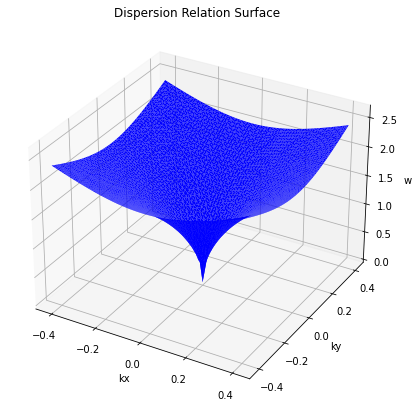

In [585]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Dispersion Relation Surface")

# disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()


In [586]:
np.max(power_Spectrum)

1580301578.0185962

In [587]:
count_greater_than_big = np.sum(power_Spectrum >= np.max(power_Spectrum)*0.2)

In [588]:
count_greater_than_big

94

In [589]:
indices_greater_than_big = np.where(power_Spectrum >= np.max(power_Spectrum)*0.2)
indices_greater_than_big

(array([409, 412, 419, 419, 420, 426, 427, 428, 428, 430, 431, 432, 432,
        433, 434, 434, 435, 435, 436, 436, 438, 439, 439, 439, 439, 440,
        441, 442, 442, 442, 443, 443, 445, 445, 446, 447, 447, 447, 448,
        449, 450, 451, 452, 453, 459, 459, 466, 734, 741, 741, 747, 748,
        749, 750, 751, 752, 753, 753, 753, 754, 755, 755, 757, 757, 758,
        758, 758, 759, 760, 761, 761, 761, 761, 762, 764, 764, 765, 765,
        766, 766, 767, 768, 768, 769, 770, 772, 772, 773, 774, 780, 781,
        781, 788, 791], dtype=int64),
 array([34, 31, 33, 34, 34, 33, 34, 31, 32, 33, 30, 34, 35, 33, 32, 34, 33,
        34, 31, 34, 34, 31, 33, 34, 34, 33, 32, 32, 34, 34, 31, 35, 32, 34,
        35, 32, 33, 34, 34, 32, 33, 33, 33, 33, 31, 32, 33, 33, 34, 35, 33,
        33, 33, 33, 34, 32, 32, 33, 34, 31, 32, 34, 31, 35, 32, 32, 34, 34,
        33, 32, 32, 33, 35, 32, 32, 35, 32, 33, 32, 34, 33, 31, 32, 36, 33,
        34, 35, 32, 33, 32, 32, 33, 35, 32], dtype=int64),
 array([25, 

In [590]:
points = list(zip(indices_greater_than_big[0], indices_greater_than_big[1], indices_greater_than_big[2]))

# Print the points
print("Points where values are greater than 0.2:")
for point in points:
    print(f"({point[0]}, {point[1]}, {point[2]})")

Points where values are greater than 0.2:
(409, 34, 25)
(412, 31, 25)
(419, 33, 26)
(419, 34, 26)
(420, 34, 26)
(426, 33, 26)
(427, 34, 26)
(428, 31, 27)
(428, 32, 26)
(430, 33, 27)
(431, 30, 27)
(432, 34, 27)
(432, 35, 27)
(433, 33, 27)
(434, 32, 27)
(434, 34, 27)
(435, 33, 27)
(435, 34, 27)
(436, 31, 27)
(436, 34, 27)
(438, 34, 27)
(439, 31, 27)
(439, 33, 27)
(439, 34, 27)
(439, 34, 28)
(440, 33, 27)
(441, 32, 27)
(442, 32, 27)
(442, 34, 27)
(442, 34, 28)
(443, 31, 28)
(443, 35, 28)
(445, 32, 28)
(445, 34, 28)
(446, 35, 28)
(447, 32, 28)
(447, 33, 28)
(447, 34, 28)
(448, 34, 28)
(449, 32, 28)
(450, 33, 28)
(451, 33, 28)
(452, 33, 28)
(453, 33, 28)
(459, 31, 29)
(459, 32, 29)
(466, 33, 29)
(734, 33, 37)
(741, 34, 37)
(741, 35, 37)
(747, 33, 38)
(748, 33, 38)
(749, 33, 38)
(750, 33, 38)
(751, 34, 38)
(752, 32, 38)
(753, 32, 38)
(753, 33, 38)
(753, 34, 38)
(754, 31, 38)
(755, 32, 38)
(755, 34, 38)
(757, 31, 38)
(757, 35, 38)
(758, 32, 38)
(758, 32, 39)
(758, 34, 39)
(759, 34, 39)
(760, 

In [591]:
points
# tiplet indices of each 

[(409, 34, 25),
 (412, 31, 25),
 (419, 33, 26),
 (419, 34, 26),
 (420, 34, 26),
 (426, 33, 26),
 (427, 34, 26),
 (428, 31, 27),
 (428, 32, 26),
 (430, 33, 27),
 (431, 30, 27),
 (432, 34, 27),
 (432, 35, 27),
 (433, 33, 27),
 (434, 32, 27),
 (434, 34, 27),
 (435, 33, 27),
 (435, 34, 27),
 (436, 31, 27),
 (436, 34, 27),
 (438, 34, 27),
 (439, 31, 27),
 (439, 33, 27),
 (439, 34, 27),
 (439, 34, 28),
 (440, 33, 27),
 (441, 32, 27),
 (442, 32, 27),
 (442, 34, 27),
 (442, 34, 28),
 (443, 31, 28),
 (443, 35, 28),
 (445, 32, 28),
 (445, 34, 28),
 (446, 35, 28),
 (447, 32, 28),
 (447, 33, 28),
 (447, 34, 28),
 (448, 34, 28),
 (449, 32, 28),
 (450, 33, 28),
 (451, 33, 28),
 (452, 33, 28),
 (453, 33, 28),
 (459, 31, 29),
 (459, 32, 29),
 (466, 33, 29),
 (734, 33, 37),
 (741, 34, 37),
 (741, 35, 37),
 (747, 33, 38),
 (748, 33, 38),
 (749, 33, 38),
 (750, 33, 38),
 (751, 34, 38),
 (752, 32, 38),
 (753, 32, 38),
 (753, 33, 38),
 (753, 34, 38),
 (754, 31, 38),
 (755, 32, 38),
 (755, 34, 38),
 (757, 3

In [592]:
kx[0,:]

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [593]:
ky[:,0]

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [594]:
w

array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
        3.13112068,  3.13635667])

In [595]:
w_new = spec3d.w
w_new

array([-3.14159265, -3.13635667, -3.13112068, ...,  3.12588469,
        3.13112068,  3.13635667])

In [596]:
points

[(409, 34, 25),
 (412, 31, 25),
 (419, 33, 26),
 (419, 34, 26),
 (420, 34, 26),
 (426, 33, 26),
 (427, 34, 26),
 (428, 31, 27),
 (428, 32, 26),
 (430, 33, 27),
 (431, 30, 27),
 (432, 34, 27),
 (432, 35, 27),
 (433, 33, 27),
 (434, 32, 27),
 (434, 34, 27),
 (435, 33, 27),
 (435, 34, 27),
 (436, 31, 27),
 (436, 34, 27),
 (438, 34, 27),
 (439, 31, 27),
 (439, 33, 27),
 (439, 34, 27),
 (439, 34, 28),
 (440, 33, 27),
 (441, 32, 27),
 (442, 32, 27),
 (442, 34, 27),
 (442, 34, 28),
 (443, 31, 28),
 (443, 35, 28),
 (445, 32, 28),
 (445, 34, 28),
 (446, 35, 28),
 (447, 32, 28),
 (447, 33, 28),
 (447, 34, 28),
 (448, 34, 28),
 (449, 32, 28),
 (450, 33, 28),
 (451, 33, 28),
 (452, 33, 28),
 (453, 33, 28),
 (459, 31, 29),
 (459, 32, 29),
 (466, 33, 29),
 (734, 33, 37),
 (741, 34, 37),
 (741, 35, 37),
 (747, 33, 38),
 (748, 33, 38),
 (749, 33, 38),
 (750, 33, 38),
 (751, 34, 38),
 (752, 32, 38),
 (753, 32, 38),
 (753, 33, 38),
 (753, 34, 38),
 (754, 31, 38),
 (755, 32, 38),
 (755, 34, 38),
 (757, 3

In [597]:
points[0]

(409, 34, 25)

In [598]:
kx_trip = []
ky_trip = []
w_trip = []

for i in range(len(points)):
    kx_trip.append( kx[0,:] [ points[i][1] ])
    ky_trip.append( ky[:,0] [ points[i][2] ])
    w_trip.append( w_new [  points[i][0] ])

In [599]:
np.array( w_trip )[47:]

array([0.70162236, 0.73827427, 0.73827427, 0.7696902 , 0.77492619,
       0.78016218, 0.78539816, 0.79063415, 0.79587014, 0.80110613,
       0.80110613, 0.80110613, 0.80634211, 0.8115781 , 0.8115781 ,
       0.82205008, 0.82205008, 0.82728607, 0.82728607, 0.82728607,
       0.83252205, 0.83775804, 0.84299403, 0.84299403, 0.84299403,
       0.84299403, 0.84823002, 0.85870199, 0.85870199, 0.86393798,
       0.86393798, 0.86917397, 0.86917397, 0.87440996, 0.87964594,
       0.87964594, 0.88488193, 0.89011792, 0.90058989, 0.90058989,
       0.90582588, 0.91106187, 0.9424778 , 0.94771378, 0.94771378,
       0.9843657 , 1.00007366])

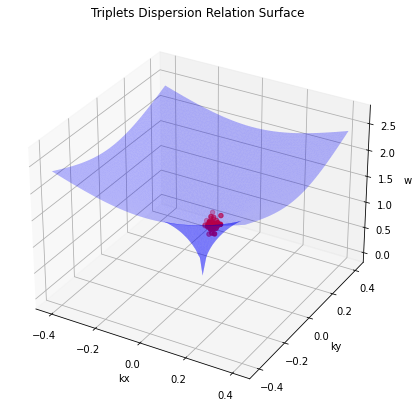

In [641]:
# Create a meshgrid for kx and ky
kx, ky = np.meshgrid(Kx, Ky)

# Assuming Ux is an array with the same shape as kx and ky
Ux_values = Uk[:,0]

# Calculate w values using the function
w_values = w_dr(kx, ky, Ux_values[:, np.newaxis, np.newaxis], 0)

# Flatten the arrays
kx_flat = kx.flatten()
ky_flat = ky.flatten()
w_values_flat = w_values.flatten()

# Plot the function in 3D space
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(kx_flat, ky_flat, w_values_flat, alpha=0.3, cmap= ListedColormap(['blue']) )#'viridis'

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

plt.title("Triplets Dispersion Relation Surface")

ax.scatter( np.array(kx_trip) [47:], np.array(ky_trip) [47:], np.array( w_trip )[47:], color='red', marker='o')

# disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

In [642]:
np.array(kx_trip) [47:]


array([ 0.        ,  0.01250385,  0.0250077 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01250385, -0.01250385, -0.01250385,
        0.        ,  0.01250385, -0.0250077 , -0.01250385,  0.01250385,
       -0.0250077 ,  0.0250077 , -0.01250385, -0.01250385,  0.01250385,
        0.01250385,  0.        , -0.01250385, -0.01250385,  0.        ,
        0.0250077 , -0.01250385, -0.01250385,  0.0250077 , -0.01250385,
        0.        , -0.01250385,  0.01250385,  0.        , -0.0250077 ,
       -0.01250385,  0.03751155,  0.        ,  0.01250385,  0.0250077 ,
       -0.01250385,  0.        , -0.01250385, -0.01250385,  0.        ,
        0.0250077 , -0.01250385])

In [643]:
np.array(ky_trip) [47:]

array([0.05001541, 0.05001541, 0.05001541, 0.06251926, 0.06251926,
       0.06251926, 0.06251926, 0.06251926, 0.06251926, 0.06251926,
       0.06251926, 0.06251926, 0.06251926, 0.06251926, 0.06251926,
       0.06251926, 0.06251926, 0.06251926, 0.07502311, 0.07502311,
       0.07502311, 0.07502311, 0.06251926, 0.07502311, 0.07502311,
       0.07502311, 0.07502311, 0.07502311, 0.07502311, 0.07502311,
       0.07502311, 0.07502311, 0.07502311, 0.07502311, 0.07502311,
       0.07502311, 0.07502311, 0.07502311, 0.08752696, 0.07502311,
       0.08752696, 0.08752696, 0.08752696, 0.08752696, 0.08752696,
       0.10003081, 0.10003081])

In [644]:
np.array( w_trip )[47:]

array([0.70162236, 0.73827427, 0.73827427, 0.7696902 , 0.77492619,
       0.78016218, 0.78539816, 0.79063415, 0.79587014, 0.80110613,
       0.80110613, 0.80110613, 0.80634211, 0.8115781 , 0.8115781 ,
       0.82205008, 0.82205008, 0.82728607, 0.82728607, 0.82728607,
       0.83252205, 0.83775804, 0.84299403, 0.84299403, 0.84299403,
       0.84299403, 0.84823002, 0.85870199, 0.85870199, 0.86393798,
       0.86393798, 0.86917397, 0.86917397, 0.87440996, 0.87964594,
       0.87964594, 0.88488193, 0.89011792, 0.90058989, 0.90058989,
       0.90582588, 0.91106187, 0.9424778 , 0.94771378, 0.94771378,
       0.9843657 , 1.00007366])

In [645]:
# slice along kx = 0
zero_indices = np.where( np.array(kx_trip) [47:] ==0 )
zero_indices

(array([ 0,  3,  4,  5,  6, 10, 21, 24, 30, 33, 37, 41, 44], dtype=int64),)

In [646]:
ky_sliced = np.array(ky_trip) [47:] [zero_indices]
ky_sliced

array([0.05001541, 0.06251926, 0.06251926, 0.06251926, 0.06251926,
       0.06251926, 0.07502311, 0.07502311, 0.07502311, 0.07502311,
       0.07502311, 0.08752696, 0.08752696])

In [647]:
w_sliced = np.array(w_trip) [47:] [zero_indices]
w_sliced

array([0.70162236, 0.7696902 , 0.77492619, 0.78016218, 0.78539816,
       0.80110613, 0.83775804, 0.84299403, 0.86393798, 0.87440996,
       0.89011792, 0.91106187, 0.94771378])

In [648]:
kx

array([[-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       ...,
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709],
       [-0.41262709, -0.40012324, -0.38761939, ...,  0.38761939,
         0.40012324,  0.41262709]])

In [653]:
kx[:,33]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [655]:
ky[:,33]

array([-0.41262709, -0.40012324, -0.38761939, -0.37511554, -0.36261169,
       -0.35010784, -0.33760399, -0.32510014, -0.31259628, -0.30009243,
       -0.28758858, -0.27508473, -0.26258088, -0.25007703, -0.23757318,
       -0.22506932, -0.21256547, -0.20006162, -0.18755777, -0.17505392,
       -0.16255007, -0.15004622, -0.13754236, -0.12503851, -0.11253466,
       -0.10003081, -0.08752696, -0.07502311, -0.06251926, -0.05001541,
       -0.03751155, -0.0250077 , -0.01250385,  0.        ,  0.01250385,
        0.0250077 ,  0.03751155,  0.05001541,  0.06251926,  0.07502311,
        0.08752696,  0.10003081,  0.11253466,  0.12503851,  0.13754236,
        0.15004622,  0.16255007,  0.17505392,  0.18755777,  0.20006162,
        0.21256547,  0.22506932,  0.23757318,  0.25007703,  0.26258088,
        0.27508473,  0.28758858,  0.30009243,  0.31259628,  0.32510014,
        0.33760399,  0.35010784,  0.36261169,  0.37511554,  0.38761939,
        0.40012324,  0.41262709])

In [656]:
w_values.shape

(680, 67, 67)

In [663]:
def sliced_at_0(ky):
    g = 9.81
    h = 1000
    return np.sqrt( g * np.abs(ky) * np.tanh( h * np.abs(ky)))

In [668]:
ky_sliced

array([0.05001541, 0.06251926, 0.06251926, 0.06251926, 0.06251926,
       0.06251926, 0.07502311, 0.07502311, 0.07502311, 0.07502311,
       0.07502311, 0.08752696, 0.08752696])

In [669]:
w_sliced

array([0.70162236, 0.7696902 , 0.77492619, 0.78016218, 0.78539816,
       0.80110613, 0.83775804, 0.84299403, 0.86393798, 0.87440996,
       0.89011792, 0.91106187, 0.94771378])

Text(0, 0.5, 'w')

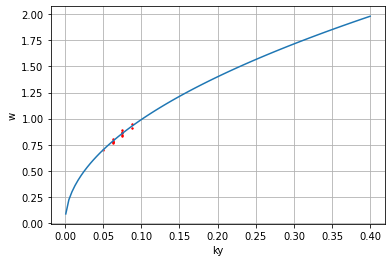

In [720]:
plt.scatter(ky_sliced, w_sliced, color = 'red', s=2)

kv = np.linspace(0.001, 0.4, 100)
plt.plot(kv, sliced_at_0(kv) )

plt.grid(True)
plt.xlabel("ky")
plt.ylabel("w")

#plt.xlim(0.05,0.1)
#plt.ylim(0.6,1)

In [672]:
np.array([sliced_at_0(0.05001541), sliced_at_0(0.06251926), sliced_at_0(0.07502311), sliced_at_0(0.08752696)])

array([0.70046497, 0.78314363, 0.85789085, 0.92662801])

In [673]:
(0.7696902 + 0.77492619 + 0.78016218 + 0.78539816 + 0.80110613)/5

0.782256572

In [674]:
(0.83775804 + 0.84299403 + 0.86393798 + 0.87440996 + 0.89011792)/5

0.861843586

In [675]:
(0.91106187 + 0.94771378)/2

0.9293878250000001

In [680]:
ky_trip = np.array([0.05001541, 0.06251926, 0.07502311, 0.08752696])
w_trip = np.array([0.70046497, 0.782256572, 0.861843586, 0.9293878250000001])

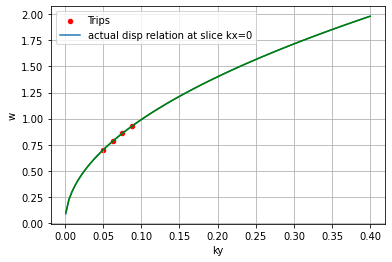

In [719]:
plt.scatter(ky_trip, w_trip, color = 'red', s=20, label="Trips")

kv = np.linspace(0.001, 0.4, 100)
plt.plot(kv, sliced_at_0(kv) , label='actual disp relation at slice kx=0')

plt.grid(True)
plt.xlabel("ky")
plt.ylabel("w")

plt.plot(kv, np.sqrt( 9.81 * kv), color = 'green')

plt.legend()

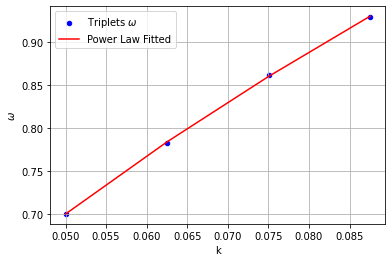

In [693]:
# Use fitting function
def power_law_function(x, a, b, c):
    return a * x**b + c

# Fit the curve
param, covariance = curve_fit(power_law_function, ky_trip, w_trip)
a, b, c = param

# Fitted curve points
k_fit = np.linspace(min(ky_trip), max(ky_trip), len(ky_trip))
y_fit = power_law_function(k_fit, a, b, c)

# Plot data and fitted curve
plt.scatter(ky_trip, w_trip, label='Triplets $\omega$ ', s=20, color='blue')
plt.plot(k_fit, y_fit, label='Power Law Fitted', color='red')

plt.ylabel('$\omega$')
plt.xlabel('k')
plt.grid(True)
plt.legend()

In [715]:
w_0 = np.sqrt( 9.81 * ky_trip)
w_0

array([0.70046497, 0.78314363, 0.85789085, 0.92662801])

In [712]:
def obj(U, w_i, w_0, k):
    return (w_i - w_0 - k*U)**2

# Initial guess for U
initial_U = [0.2, 0.24, 0.26, 0.29]

# Perform the least squares fit using least_squares
result = least_squares(obj, initial_U, args=(w_trip, w_0 ,ky_trip))

# Optimized U values
optimized_U = result.x

# Print the optimized U values
print("Optimized U values:", optimized_U)

Optimized U values: [0.02500003 0.01758506 0.07860106 0.06383961]


Text(0.5, 0, 'k')

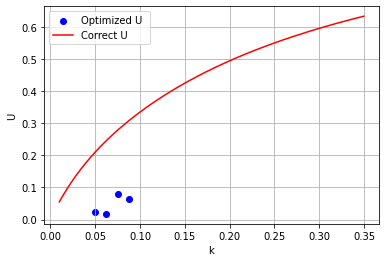

In [706]:
plt.scatter(ky_trip, optimized_U, label='Optimized U ', color='blue')
plt.plot(k, Uk[:,0], label = 'Correct U', color='red')

plt.grid(True)
plt.legend()
plt.ylabel("U")
plt.xlabel("k")

In [291]:
surf3d = surface_core.surface_from_file("C:\\Users\josep\Desktop\PHYC40900_Project TP\Data_NEW\shearing_curr_res_7.5_dt_1.0_T_1200_U_1.0exp(0.5z)+0.05_psi_0_smax_30_0_surf3d.hdf5")
spec3d = surf3d.define_SpectralAnalysis()

In [292]:
def plot_disp_shell(axes, h, z, U, psi, label='', plot_type='surf', linestyles='line', put_clabel=True):
    g = 9.81
    alpha = 1 # value that defines opacity in plot
    dk = 0.005
    k = np.arange(0.01, 0.4, dk)
    dtheta=0.05
    theta=np.arange(0, 2*np.pi+dtheta, dtheta)
    kk, th = np.meshgrid(k, theta, indexing='ij')
    U_eff = 2*kk*np.sum(U*np.exp(np.outer(2*kk,z)), axis=1).reshape(kk.shape)*np.abs(z[1]-z[0])
    ww = kk*U_eff*np.cos(theta-psi) + np.sqrt(kk*g*np.tanh(kk*h))
    kx = kk*np.cos(th)
    ky = kk*np.sin(th)
    if plot_type=='surf':
        axes.plot_surface(kx, ky, ww, alpha=alpha, label=label, color = 'red')
        axes.set_xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$')
        axes.set_ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        axes.set_zlabel(r'$\omega~[\mathrm{rad~s}^{-1}]$')
    elif plot_type=='contour':
        levels = [0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2, 2.2, 2.4, 2.5]
        c = plt.contour(kx, ky, ww, levels=levels, linestyles=linestyles, colors = 'red')#, label=label)
        if put_clabel:
            plt.clabel(c)
        plt.xlabel(r'$k_x~[\mathrm{rad~m}^{-1}]$') 
        plt.ylabel(r'$k_y~[\mathrm{rad~m}^{-1}]$')
        plt.axis('equal')
        
    return kx, ky, ww

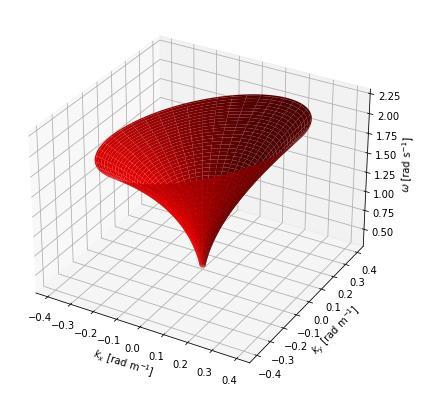

In [293]:
fig = plt.figure(figsize=(7,7))
axes = fig.add_subplot(111, projection='3d')
disp_kx, disp_ky, disp_ww = plot_disp_shell(axes, h=1000, z = z, U = U, psi = 0)

In [294]:
matrix_disp_r = np.sqrt( (disp_kx)**2 + (disp_ky)**2 )

In [295]:
disp_r = matrix_disp_r[:,0]

In [296]:
matrix_disp_theta = np.arctan2(disp_ky,disp_kx)

In [297]:
disp_theta = matrix_disp_theta[0]

In [298]:
nearest_index = np.argmin(np.abs(disp_theta - 0))

In [299]:
disp_ww_for_theta = disp_ww[:, nearest_index]

(0.0, 0.36)

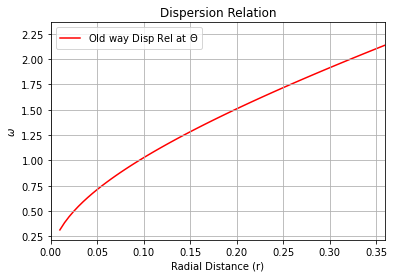

In [320]:
plt.plot(disp_r, disp_ww_for_theta, color='red',zorder=0, label = 'Old way Disp Rel at $\Theta$')
plt.grid(True)
plt.xlabel('Radial Distance (r)')
plt.ylabel('$\omega$')
plt.title("Dispersion Relation")
plt.legend()

plt.xlim(0,0.36)

In [304]:
# Define the function w_dr
def w_dr(kx, ky, Ux):
    return np.sqrt(g * np.sqrt(kx**2 + ky**2) * np.tanh(h * np.sqrt(kx**2 + ky**2))) + kx * Ux + ky * Uy

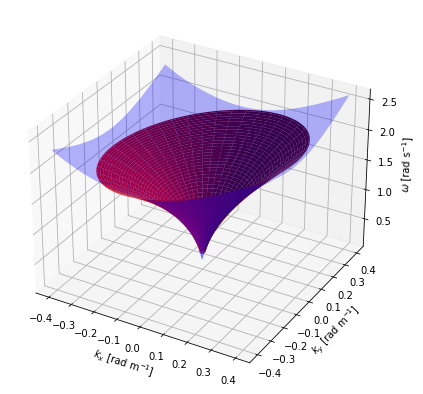

In [310]:
# Given values
g = 9.81
h = 1000 # Adjust this value if needed
Uy = 0.0

# Generate kx, ky values
kx = np.linspace(-0.4, 0.4, 680)
ky = np.linspace(-0.4, 0.4, 680)
kx, ky = np.meshgrid(kx, ky)

# Generate Ux array
Ux = Uk[:,0] # (your provided values) ... , 0.63330752])

# Calculate w values using the w_dr function
w = w_dr(kx, ky, Ux)

# Plot the surface
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(kx, ky, w, alpha = 0.3,  cmap= ListedColormap(['blue'])) #cmap='viridis')

# Set labels
ax.set_xlabel('kx')
ax.set_ylabel('ky')
ax.set_zlabel('w')

disp_kx, disp_ky, disp_ww = plot_disp_shell(ax, h=1000, z = z, U = U, psi = 0)

# Show the plot
plt.show()

In [258]:
kx[0,:].shape

(680,)

In [267]:
np.min( w[0, :] )

1.9660130131156015

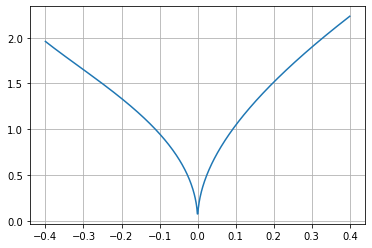

In [323]:
plt.plot(kx[340, :], w[340, :])

plt.grid(True)

In [245]:
w[0,:]

array([2.33373248, 2.3310624 , 2.32840757, 2.32576781, 2.32314293,
       2.32053278, 2.31793718, 2.31535598, 2.31278902, 2.31023613,
       2.30769717, 2.305172  , 2.30266045, 2.3001624 , 2.29767769,
       2.2952062 , 2.29274779, 2.29030233, 2.28786969, 2.28544974,
       2.28304236, 2.28064743, 2.27826484, 2.27589446, 2.27353619,
       2.27118991, 2.26885552, 2.2665329 , 2.26422197, 2.2619226 ,
       2.25963472, 2.25735821, 2.25509299, 2.25283896, 2.25059603,
       2.24836411, 2.24614311, 2.24393296, 2.24173356, 2.23954484,
       2.23736671, 2.23519911, 2.23304194, 2.23089515, 2.22875865,
       2.22663238, 2.22451626, 2.22241023, 2.22031423, 2.21822818,
       2.21615203, 2.21408571, 2.21202916, 2.20998233, 2.20794516,
       2.20591759, 2.20389956, 2.20189103, 2.19989194, 2.19790223,
       2.19592187, 2.19395081, 2.19198899, 2.19003636, 2.1880929 ,
       2.18615854, 2.18423325, 2.182317  , 2.18040972, 2.1785114 ,
       2.17662199, 2.17474145, 2.17286974, 2.17100684, 2.16915